In [429]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KernelDensity
import numpy as np
from numpy import array, linspace
from scipy.signal import argrelextrema
from sklearn.cross_validation import LeaveOneOut
import jenkspy

In [4]:
#Setting the filepath and loading in a shapefile
file = "./files/countries.shp"
map_df = gpd.read_file(file)

#Loading the datasets & doing some data processing like column re-naming
df = pd.read_csv('./files/index.csv')
lang = pd.read_csv('./files/languages.csv', encoding = 'cp1252')
lang.columns = ['lang_id', 'code', 'language_name', 'perc_of_people_spoken', 'official']
countries = pd.read_csv('./files/countries.csv', encoding = 'cp1252')
countries.columns = ['country_name', 'iso_2', 'code']
df.columns = ['rank', 'code', 'country', 'ethnic_index', 'cultural_index']
regions = pd.read_csv('./files/regions.csv')

In [5]:
#Merging shp and file with the cultural index file to build a map based on the data
#As every language is in a separate row, aggregating the languages, % of people spoken and the language status
merged_index = map_df.set_index('ADM0_A3').join(df.set_index('code')).reset_index()
lang['aggregated'] = lang.iloc[:,2]+' (' + lang.iloc[:,3].astype(str) + '; ' +lang.iloc[:,4] + ')'
pvt = lang[['lang_id','code','aggregated']].pivot_table(index = 'code',columns = 'aggregated')
final_aggreg = pd.DataFrame(pvt.apply(lambda x: x.dropna().reset_index()['aggregated'].tolist(), axis = 1)).reset_index()
final_aggreg.columns = ['code', 'lang']
merged_lang = merged_index.set_index('ADM0_A3').join(final_aggreg.set_index('code')).reset_index()

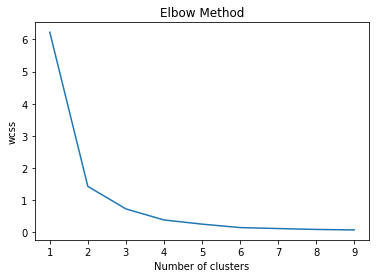

,cultural_index
class,
0,37
1,36
2,45
3,31


In [456]:
#To identify natural breaks, we will used K-means clustering algorithm. K-means is a simple unsupervised machine learning algorithm that groups a dataset into a user-specified number (k) of clusters. Dropping NAs as the K-means 'doesnt tolerate' missing values.
x = df[['cultural_index']].dropna()
#Although it's recommended to have between 5 and 10 categories, but we will use the elbow method to identify the number of classes
#The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10 in the examples above). The idea is to find the # of clusters where Within Cluster Sum of Squares is min. 
wcss = []
for i in range(1, 10):
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
_ = plt.plot(range(1,10), wcss)
_ = plt.title('Elbow Method')
_ = plt.xlabel('Number of clusters')
_ = plt.ylabel('wcss')
plt.show()
#Elbow at k=4 indicating 4 is the best number of clusters.
#Fitting kmeans to the dataset with k=4
km = KMeans(n_clusters = 4, random_state = 0)
y_means = km.fit_predict(x)
df_mean = pd.DataFrame(index = x.index, data = y_means).join(x)
df_mean.columns = ['class', 'cultural_index']
#Checking the # of observations in every class
df_mean.groupby('class').count()

{'bandwidth': 0.03442567567567568}


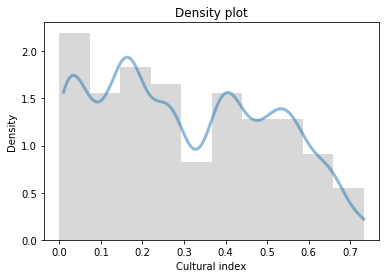

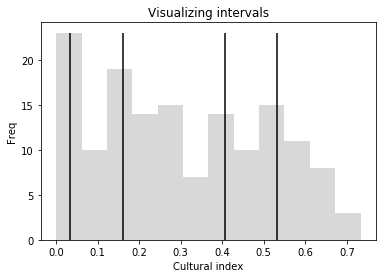

In [484]:
#Alternatively, we will use kernel density estimation
#Reshaping the data
df_set = df[['cultural_index']].dropna()
x = np.array(df_set.iloc[:,0].tolist())
X = x.reshape(-1, 1)
x_grid = np.linspace(0.01, x.max(), len(x))
#Finding the optimal bandwidth
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': x_grid}, cv = 20)

grid.fit(X)
print(grid.best_params_)
kde = grid.best_estimator_
pdf = np.exp(kde.score_samples(x_grid[:, None]))
#Ploting the density and histogram
fig, ax = plt.subplots()
_ = ax.plot(x_grid, pdf, linewidth = 3, alpha = 0.5)
_ = ax.hist(x, fc = 'gray', histtype = 'stepfilled', alpha = 0.3, normed = True)
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Density')
_ = plt.title('Density plot')
mi, ma = argrelextrema(pdf, np.less)[0], argrelextrema(pdf, np.greater)[0]
#print("Minima:", x_grid[mi])
#print("Maxima:", x_grid[ma])
#ar = x[x < x_grid[mi][0]], x[(x >= x_grid[mi][0]) * (x < x_grid[mi][1])], x[(x >= x_grid[mi][1]) * (x < x_grid[mi][2])], x[(x >= x_grid[mi][2]) * (x < x_grid[mi][3])],x[(x >= x_grid[mi][3]) * (x < x_grid[mi][4])], x[x >= x_grid[mi][5]]
def cls_kern(X):
    '''The function assigns lables depending on which interval a data point falls into'''
    for x in X:
        if x < x_grid[ma][0]: return '1'
        elif (x >= x_grid[ma][0]) * (x < x_grid[ma][1]): return '2'
        elif (x >= x_grid[ma][1]) * (x < x_grid[ma][2]): return '3'
        else: return '4'
df_set['class'] = df_set[['cultural_index']].apply(cls_kern, axis = 1)
#Checking the # of observations in every class
df_set.groupby('class').count()
#Visualizing the breaks
plt.figure()
_ = plt.hist(x, bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('Visualizing intervals')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
for p in x_grid[ma]:
    plt.vlines(p, ymin = 0, ymax = max(hist[0]))

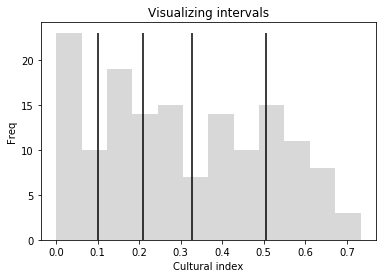

In [481]:
#Implementing Jenks Natural Breaks. I have used the optimum # of classes identified with the Elbow method
jnks = jenkspy.jenks_breaks(x, nb_class = 5)
def cls_jenks(X):
    '''The function assigns lables depending on which interval a data point falls into'''
    for x in X:
        if x < jnks[1]: return '1'
        elif (x >= jnks[1]) * (x < jnks[2]): return '2'
        elif (x >= jnks[2]) * (x < jnks[3]): return '3'
        else: return '4'
df_set['class'] = df_set[['cultural_index']].apply(cls_jenks, axis = 1)
#Checking the # of observations in every class
df_set.groupby('class').count()
#Visualizing the intervals
plt.figure()
hist = plt.hist(x, bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('Visualizing intervals')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
for b in jnks[1:-1]:
    plt.vlines(b, ymin = 0, ymax = max(hist[0]))

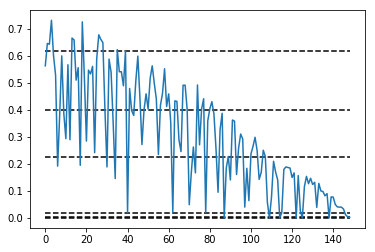

In [427]:
#A long method to implement the Jenks natural breaks algorithm
def get_jenks_breaks(data_list, number_class):
    data_list.sort()
    mat1 = []
    for i in range(len(data_list) + 1):
        temp = []
        for j in range(number_class + 1):
            temp.append(0)
        mat1.append(temp)
    mat2 = []
    for i in range(len(data_list) + 1):
        temp = []
        for j in range(number_class + 1):
            temp.append(0)
        mat2.append(temp)
    for i in range(1, number_class + 1):
        mat1[1][i] = 1
        mat2[1][i] = 0
        for j in range(2, len(data_list) + 1):
            mat2[j][i] = float('inf')
    v = 0.0
    for l in range(2, len(data_list) + 1):
        s1 = 0.0
        s2 = 0.0
        w = 0.0
        for m in range(1, l + 1):
            i3 = l - m + 1
            val = float(data_list[i3 - 1])
            s2 += val * val
            s1 += val
            w += 1
            v = s2 - (s1 * s1) / w
            i4 = i3 - 1
            if i4 != 0:
                for j in range(2, number_class + 1):
                    if mat2[l][j] >= (v + mat2[i4][j - 1]):
                        mat1[l][j] = i3
                        mat2[l][j] = v + mat2[i4][j - 1]
        mat1[l][1] = 1
        mat2[l][1] = v
    k = len(data_list)
    kclass = []
    for i in range(number_class + 1):
        kclass.append(min(data_list))
    kclass[number_class] = float(data_list[len(data_list) - 1])
    count_num = number_class
    while count_num >= 2:  # print "rank = " + str(mat1[k][count_num])
        idx = int((mat1[k][count_num]) - 2)
        # print "val = " + str(data_list[idx])
        kclass[count_num - 1] = data_list[idx]
        k = int((mat1[k][count_num] - 1))
        count_num -= 1
    return kclass

breaks = get_jenks_breaks(X, 5)

for line in breaks:
    plt.plot([line for _ in range(len(x))], 'k--')
plt.plot(x)
plt.show()

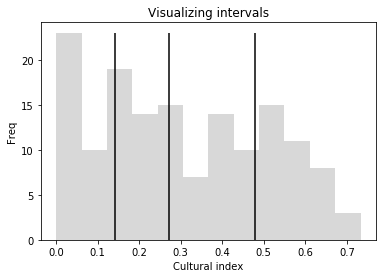

In [496]:
#Finding intervals based on percentiles
prcntl = np.percentile(x, [25,50,75])
def cls_prcntl(X):
    '''The function assigns lables depending on which interval a data point falls into'''
    for x in X:
        if x < prcntl[0]: return '1'
        elif (x >= prcntl[0]) * (x < prcntl[1]): return '2'
        else: return '3'
df_set['class'] = df_set[['cultural_index']].apply(cls_prcntl, axis = 1)
#Checking the # of observations in every class
df_set.groupby('class').count()
#Visualizing the intervals
plt.figure()
hist = plt.hist(x, bins = 12, histtype = 'stepfilled', fc = 'gray', alpha = 0.3)
_ = plt.title('Visualizing intervals')
_ = plt.xlabel('Cultural index')
_ = plt.ylabel('Freq')
for b in prcntl:
    plt.vlines(b, ymin = 0, ymax = max(hist[0]))